In [1]:
from torch import cuda
import splitfolders
import os

In [2]:
cuda.is_available()

True

In [3]:
splitfolders.ratio("dataset", output="train_test_split", seed=1337, ratio=(.9, .0, .1), group_prefix=None)

In [4]:
cwd = os.getcwd()
dataset_path = cwd + "/train_test_split/"
train_path = dataset_path + "/train/"
test_path = dataset_path + "/test/"

In [17]:
# import imghdr
# import pathlib

# for ds in [train_path,test_path]:
#   for path in os.listdir(ds):
#       filepath = pathlib.Path(str(ds)+'/'+path)
#       for file in os.listdir(filepath):
#           currfilepath = str(filepath)+'/'+file
#           if imghdr.what(currfilepath) != 'png':
#               print(f'Found broken file! : {file}')
#               os.remove(os.path.join(path, currfilepath))

Found broken file! : RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png
Found broken file! : Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png


In [6]:
import torchvision.transforms as transforms
h = w = 28
channels = 1
batch_size = 64
train_transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),    
])
test_transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
])

In [7]:
import torchvision
from torch.utils.data import DataLoader

In [19]:
tr_data = torchvision.datasets.ImageFolder(root=train_path, transform=train_transform)
tst_data = torchvision.datasets.ImageFolder(root=test_path, transform=train_transform)

In [20]:
train_loader = DataLoader(tr_data, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(tst_data, batch_size=batch_size, shuffle=False, num_workers=0)

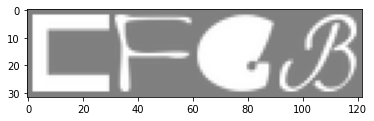

    C     F     G     B


In [10]:
import matplotlib.pyplot as plt
import numpy as np

classes = os.listdir(train_path)
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images[:4]))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [11]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
print(device)

cuda:0


In [21]:
#Dense cnn
model = torch.nn.Sequential(
    torch.nn.Conv2d(3, 32, 4, stride=2, padding=1),
    torch.nn.LeakyReLU(),
    torch.nn.Conv2d(32, 16, 2, stride=1, padding=0),
    torch.nn.LeakyReLU(),
    torch.nn.Conv2d(16, 8, 2, stride=1, padding=0),
    torch.nn.LeakyReLU(),
    torch.nn.Flatten(),
    torch.nn.Linear(1152, 512),
    torch.nn.Linear(512, 128),
    torch.nn.Linear(128, 10)   
)

In [22]:
len(classes)

10

In [25]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [26]:
# model.to(device)
for epoch in range(30):
    for data in train_loader:
        image, label = data
#         image = image.to(device)
#         label = label.to(device)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
    print(epoch, loss)

0 tensor(0.0879, grad_fn=<NllLossBackward0>)
1 tensor(3.4816e-05, grad_fn=<NllLossBackward0>)
2 tensor(0.0012, grad_fn=<NllLossBackward0>)
3 tensor(0.0003, grad_fn=<NllLossBackward0>)
4 tensor(0.0005, grad_fn=<NllLossBackward0>)
5 tensor(0.0014, grad_fn=<NllLossBackward0>)
6 tensor(6.4326e-05, grad_fn=<NllLossBackward0>)
7 tensor(0.0009, grad_fn=<NllLossBackward0>)
8 tensor(0.0004, grad_fn=<NllLossBackward0>)
9 tensor(8.4503e-05, grad_fn=<NllLossBackward0>)
10 tensor(0.0003, grad_fn=<NllLossBackward0>)
11 tensor(1.8814e-05, grad_fn=<NllLossBackward0>)
12 tensor(3.8444e-06, grad_fn=<NllLossBackward0>)
13 tensor(1.9151e-05, grad_fn=<NllLossBackward0>)
14 tensor(0.0004, grad_fn=<NllLossBackward0>)
15 tensor(9.2387e-07, grad_fn=<NllLossBackward0>)
16 tensor(1.6490e-06, grad_fn=<NllLossBackward0>)
17 tensor(0.0003, grad_fn=<NllLossBackward0>)
18 tensor(0.0010, grad_fn=<NllLossBackward0>)
19 tensor(0.0001, grad_fn=<NllLossBackward0>)
20 tensor(0.0003, grad_fn=<NllLossBackward0>)
21 tensor(0.